# Email clustering

In [43]:
import re
import pandas as pd
import pickle
import os.path
from nltk.corpus import stopwords
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [44]:
creds = None

In [45]:
def gmail_metadata(creds = None):
    
    SCOPES = ['https://www.googleapis.com/auth/gmail.readonly', 
          'https://www.googleapis.com/auth/gmail.send', 
          'https://www.googleapis.com/auth/gmail.labels', 
          'https://www.googleapis.com/auth/gmail.modify']
    
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)
            
    service = build('gmail', 'v1', credentials=creds)
    results = service.users().messages().list(userId='me',labelIds = ['INBOX']).execute()
    messages = results.get('messages', [])
    
    return service, results, messages

In [46]:
service, results, messages = gmail_metadata()

In [47]:
def clean(text):
    
    clean_text = ''.join([i for i in re.sub('\W+',' ', text.lower()) if not i.isdigit()]).replace('x', '')
    final = ' '.join([item for item in clean_text.split(' ') if item not in stopwords.words('english')])
    final = final.encode("ascii", errors="ignore").decode()
    final = final.replace('giorgos', '')
    
    return final

In [48]:
msg_list = []

for message in messages:
    msg = service.users().messages().get(userId='me', id=message['id']).execute()
    msg_list.append(msg['snippet'])

msg_df = pd.DataFrame(msg_list, columns=['text'])

In [51]:
msg_df['text'].iloc[:10]

0    Hi George, Looking for an interesting way to w...
1    Have you created a data project yet? Data proj...
2    Hi Giorgos, We have new jobs for you, includin...
3    Stories for Giorgos Today&#39;s highlights Dat...
4    View online reed.co.uk reed.co.uk Love Mondays...
5    Here are the top changes expected after the cr...
6    You know more people on LinkedIn than you thin...
7    Answer: I&#39;m assuming that you have a relev...
8    Answer: I have compiled several data sets for ...
9    Hi Giorgos, We have new jobs for you, includin...
Name: text, dtype: object

In [11]:
msg_df = msg_df['text'].apply(clean)

In [12]:
vect = CountVectorizer()
X = vect.fit_transform(msg_df)

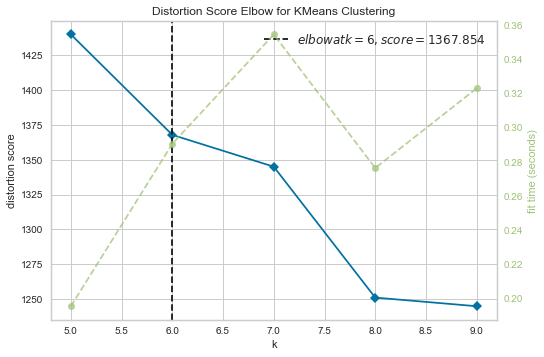

In [20]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(5,10))

visualizer.fit(X)
visualizer.show()

In [21]:
n_clusters = 6
model = KMeans(n_clusters)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [22]:
centers = model.cluster_centers_.argsort()[:, ::-1]
terms = vect.get_feature_names()

In [23]:
for i in range(n_clusters):
    print('cluster :', i),
    
    for ind in centers[i, :4]:
        print(terms[ind])

cluster : 0
people
linkedin
know
find
cluster : 1
jobs
hi
interested
latest
cluster : 2
share
view
social
browser
cluster : 3
data
today
highlights
science
cluster : 4
stories
answer
quora
data
cluster : 5
jobs
uk
co
trending


In [24]:
y_pred = vect.transform(["Search for jobs in UK in data science"])
prediction = model.predict(y_pred)
print('New text belongs to cluster:', prediction)

New text belongs to cluster: [4]
